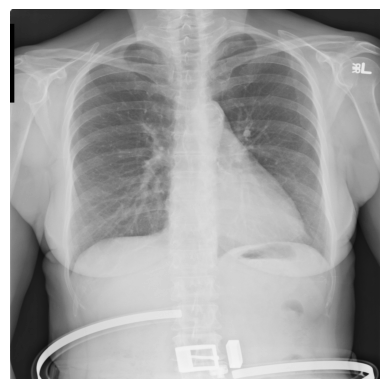

In [1]:
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

image_dir = 'images_001/images'

def display_first_image(directory):
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    
    if not image_files:
        print("No image files found in the directory.")
        return
    
    first_image_file = image_files[24]
    img_path = os.path.join(directory, first_image_file)
    
    try:
        img = Image.open(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error opening {img_path}: {e}")

display_first_image(image_dir)


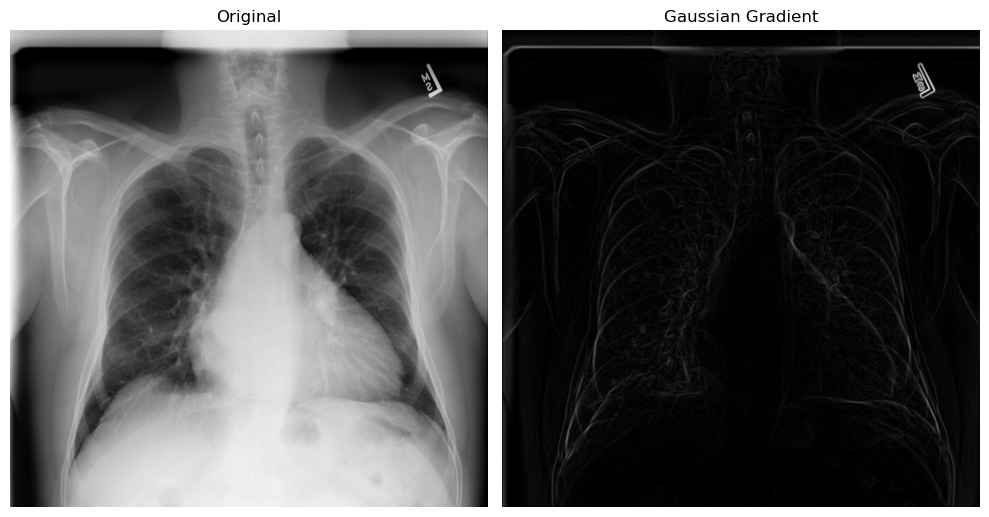

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os

def display_first_image_and_gradient(directory):
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    if not image_files:
        print("No image files found in the directory.")
        return

    first_image_file = image_files[1]
    img_path = os.path.join(directory, first_image_file)

    try:
        # Changing image to grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to load image {img_path}")
            return

        # Using GaussianBlur
        blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

        # Calculating gradients using the Sobel operator
        sobelx = cv2.Sobel(blurred_img, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(blurred_img, cv2.CV_64F, 0, 1, ksize=5)
        
        # Computing the gradient magnitude
        gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)

        # Normalizing the gradient_magnitude to 0-255 and convert to type 'uint8'
        gradient_magnitude = (gradient_magnitude / gradient_magnitude.max()) * 255
        gradient_magnitude = gradient_magnitude.astype(np.uint8)

        xray_image_laplace_gaussian = ndimage.gaussian_laplace(img, sigma=1)
        
        # Normalizing the image for display
        xray_image_laplace_gaussian = cv2.normalize(xray_image_laplace_gaussian, None, 0, 255, cv2.NORM_MINMAX)
        xray_image_laplace_gaussian = xray_image_laplace_gaussian.astype(np.uint8)

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

        #original image
        axes[0].set_title("Original")
        axes[0].imshow(img, cmap="gray")
        axes[0].axis("off")

        #gradient image
        axes[1].set_title("Gaussian Gradient")
        axes[1].imshow(gradient_magnitude, cmap="gray")
        axes[1].axis("off")

        # axes[1].set_title("Laplacian of Gaussian")
        # axes[1].imshow(xray_image_laplace_gaussian, cmap='gray')
        # axes[1].axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing image: {e}")

image_dir = 'images_001/images'
display_first_image_and_gradient(image_dir)


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def segment_disease_area(directory):
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    if not image_files:
        print("No image files found in the directory.")
        return

    first_image_file = image_files[0]
    img_path = os.path.join(directory, first_image_file)

    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to load image {img_path}")
            return

        # Applying GaussianBlur to the image
        blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

        # Calculating gradients using the Sobel operator
        sobelx = cv2.Sobel(blurred_img, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(blurred_img, cv2.CV_64F, 0, 1, ksize=5)
        
        # Computing the gradient magnitude
        gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)

        # Normalizing to 0-255 and convert to type 'uint8'
        gradient_magnitude = (gradient_magnitude / gradient_magnitude.max()) * 225

        gradient_magnitude = gradient_magnitude.astype(np.uint8)

            # Thresholding the gradient to get significant edges
        _, thresh = cv2.threshold(gradient_magnitude,4, 225, cv2.THRESH_BINARY)

        # Finding contours from the thresholded gradient image
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Making an assumption the disease is the largest highlighted area in the middle of the image
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        disease_contour = None
        for contour in contours:
            M = cv2.moments(contour)
            if M['m00'] == 0:
                continue
            cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
            if cx > img.shape[1] * 0.3 and cx < img.shape[1] * 0.7:
                disease_contour = contour
                break

        if disease_contour is None:
            print("No disease area detected.")
            return

        # Creating a mask from the contour
        mask = np.zeros_like(img)
        cv2.drawContours(mask, [disease_contour], -1, color=255, thickness=cv2.FILLED)

        # Highlighting the disease area on the original image
        highlighted_disease_area = cv2.bitwise_and(img, img, mask=mask)

        # Displaying the result
        plt.figure(figsize=(8, 8))
        plt.imshow(highlighted_disease_area, cmap='gray')
        plt.title('Disease Area Segmented')
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error segmenting disease area: {e}")

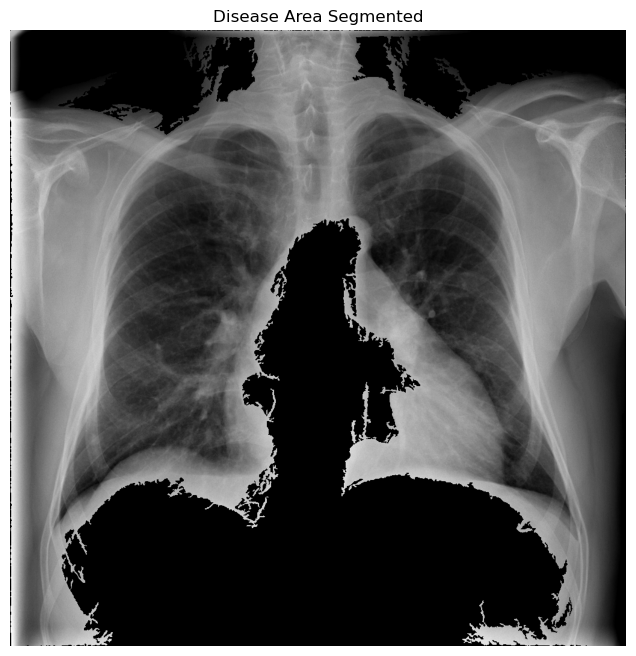

In [4]:
image_dir = r'images_001/images' # Update to the correct path
segment_disease_area(image_dir)

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def segment_cardiomegaly(directory):
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    if not image_files:
        print("No image files found in the directory.")
        return

    first_image_file = image_files[84]
    img_path = os.path.join(directory, first_image_file)

    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to load image {img_path}")
            return
        
        # Enhancing contrast using histogram equalization
        equalized_img = cv2.equalizeHist(img)

        # Using edge detection or thresholding to identify the boundaries of the heart
        edges = cv2.Canny(equalized_img, threshold1=70, threshold2=60)
        
        # Finding contours from the edges
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Making an assumption the disease is the largest highlighted area in the middle of the image
        # contours = sorted(contours, key=cv2.contourArea, reverse=True)
        # disease_contour = None
        # for contour in contours:
        #     M = cv2.moments(contour)
        #     if M['m00'] == 0:
        #         continue
        #     cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
        #     if cx > img.shape[1] * 0.3 and cx < img.shape[1] * 0.7:
        #         disease_contour = contour
        #         break

        # if disease_contour is None:
        #     print("No disease area detected.")
        #     return

        # Making an assumption that the largest contour in the upper half of the image is the heart
        half_y = img.shape[0] // 2
        upper_half_contours = [cnt for cnt in contours if cv2.boundingRect(cnt)[1] < half_y]
        heart_contour = max(upper_half_contours, key=cv2.contourArea)

        mask = np.zeros_like(img)
        cv2.drawContours(mask, [heart_contour], -1, 255, -1)  # Fill the contour


        # Calculating the ratio of the heart size to the chest cavity
        heart_area = cv2.contourArea(heart_contour)
        chest_area = img.shape[0] * img.shape[1]
        ratio = heart_area / chest_area

        # Displaying the original image with the segmented heart area
        plt.figure(figsize=(10, 10))
        plt.subplot(121)
        plt.imshow(edges, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(122)
        plt.imshow(mask, cmap='gray')
        plt.title('Segmented Heart Area')
        plt.axis('off')
        plt.show()

        print(f"Heart to chest area ratio: {ratio:.2f}")

        if ratio > 0.5:  # This is a simplistic threshold and may not be medically accurate
            print("Cardiomegaly may be present.")
        else:
            print("Cardiomegaly is not present based on the ratio.")

    except Exception as e:
        print(f"Error segmenting cardiomegaly: {e}")



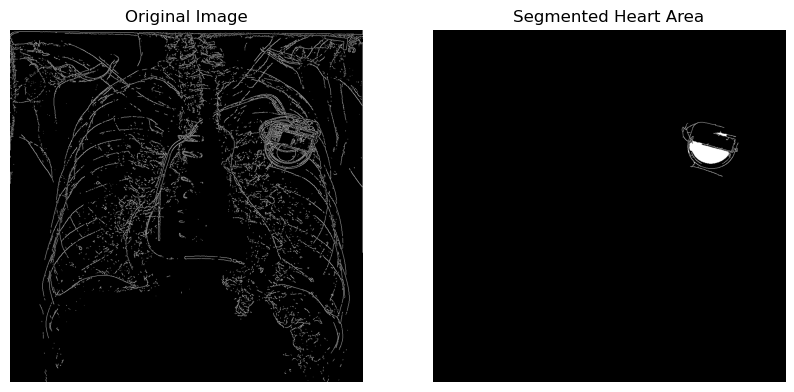

Heart to chest area ratio: 0.00
Cardiomegaly is not present based on the ratio.


In [6]:
image_dir = r'images_001/images' # Update to the correct path
segment_cardiomegaly(image_dir)

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def segment_heart_area(directory):
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    if not image_files:
        print("No image files found in the directory.")
        return

    first_image_file = image_files[0]
    img_path = os.path.join(directory, first_image_file)

    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to load image {img_path}")
            return
        
        # Preprocessing: enhance contrast and apply blur
        img_enhanced = cv2.equalizeHist(img)
        img_blurred = cv2.GaussianBlur(img_enhanced, (5, 5), 0)

        # Thresholding to identify potential heart regions
        _, binary_img = cv2.threshold(img_blurred, 130, 255, cv2.THRESH_BINARY_INV)

        # Using Morphological opening to remove small objects
        kernel = np.ones((10, 10), np.uint8)
        morph_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)

        # Finding contours
        contours, _ = cv2.findContours(morph_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Making an assumption heart is the largest contour in the central region of the image
        h, w = img.shape
        central_contours = [cnt for cnt in contours if cv2.boundingRect(cnt)[0] > w * 0.2 and cv2.boundingRect(cnt)[0] < w * 0.8]
        heart_contour = max(central_contours, key=cv2.contourArea) if central_contours else None

        if heart_contour is None:
            print("Heart contour could not be identified.")
            return

        # Creating a mask from the heart contour
        mask = np.zeros_like(img)
        cv2.drawContours(mask, [heart_contour], -1, 255, -1)  # Fill the contour

        # Calculating the ratio of the heart size to the chest cavity
        heart_area = cv2.contourArea(heart_contour)
        chest_area = img.shape[0] * img.shape[1]
        ratio = heart_area / chest_area
        print(heart_area)
        print(chest_area)

        # Displaying the result
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(heart_area, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Segmented Heart Area')
        plt.axis('off')

        plt.show()

        print(f"Heart to chest area ratio: {ratio:.2%}")

        # Defining a threshold ratio for cardiomegaly, e.g., 50% of the thoracic cavity
        threshold_ratio = 0.5
        if ratio > threshold_ratio:
            print("Potential cardiomegaly detected.")
        else:
            print("Cardiomegaly not detected based on area ratio.")

    except Exception as e:
        print(f"Error segmenting heart area: {e}")



265887.5
1048576
Error segmenting heart area: Invalid shape () for image data


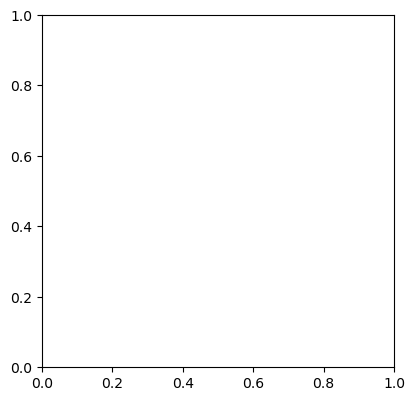

In [4]:
image_dir = r'images_001/images' # Update to the correct path
segment_heart_area(image_dir)

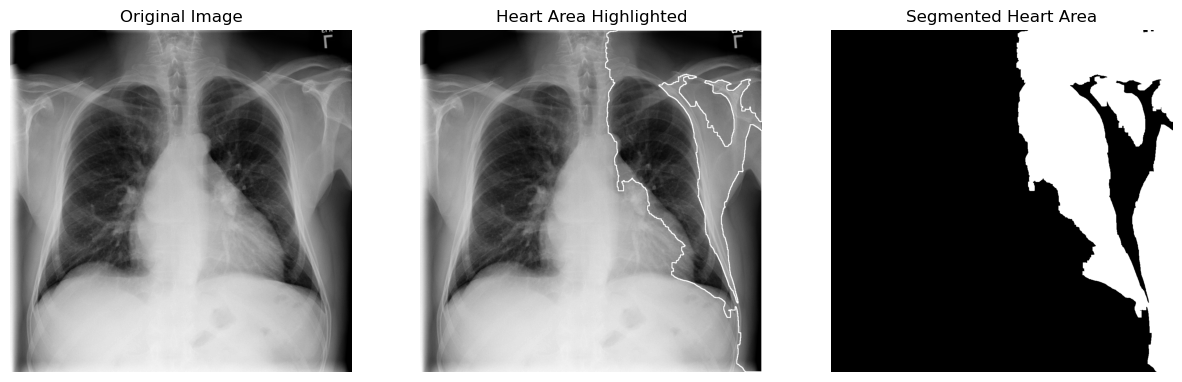

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def segment_and_plot_heart_area(directory):
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    
    if not image_files:
        print("No image files found in the directory.")
        return

    first_image_file = image_files[0]
    img_path = os.path.join(directory, first_image_file)

    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to load image {img_path}")
            return

        # Preprocessing
        img_enhanced = cv2.equalizeHist(img)
        img_blurred = cv2.GaussianBlur(img_enhanced, (5, 5), 0)

        # Thresholding
        _, binary_img = cv2.threshold(img_blurred, 130, 255, cv2.THRESH_BINARY_INV)

        # Morphological opening
        kernel = np.ones((10, 10), np.uint8)
        morph_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)

        # Finding contours
        contours, _ = cv2.findContours(morph_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        central_contours = [cnt for cnt in contours if cv2.boundingRect(cnt)[0] > img.shape[1] * 0.2 and cv2.boundingRect(cnt)[0] < img.shape[1] * 0.8]
        heart_contour = max(central_contours, key=cv2.contourArea) if central_contours else None

        if heart_contour is None:
            print("Heart contour could not be identified.")
            return

        # Masking for the heart area
        mask = np.zeros_like(img)
        cv2.drawContours(mask, [heart_contour], -1, 255, -1)

        # Highlighting the heart area on the original image
        img_with_heart = img.copy()
        cv2.drawContours(img_with_heart, [heart_contour], -1, (255, 0, 0), 2)

        # Displaying the results
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(img_with_heart, cmap='gray')
        plt.title('Heart Area Highlighted')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(mask, cmap='gray')
        plt.title('Segmented Heart Area')
        plt.axis('off')

        plt.show()

    except Exception as e:
        print(f"Error segmenting and plotting heart area: {e}")

# Example usage
image_dir = r'images_001/images'  # Update to the correct path
segment_and_plot_heart_area(image_dir)


Lung Areas: [538922.0, 782.0]
Heart Area: 377.5


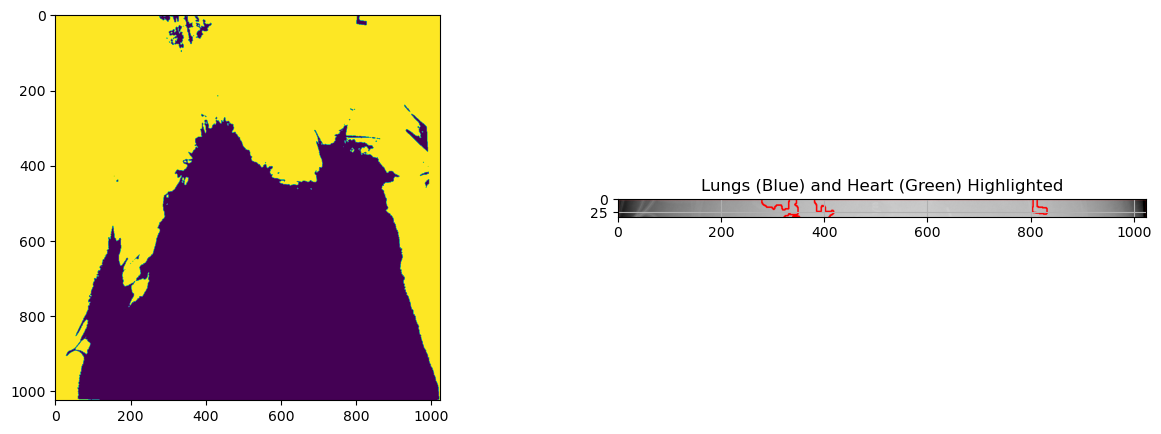

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def segment_lungs_and_heart(image_path):
    image_files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]
    
    if not image_files:
        print("No image files found in the directory.")
        return

    first_image_file = image_files[168]
    img_path = os.path.join(image_path, first_image_file)

    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to load image {img_path}")
            return

        # Enhancing contrast
        img_enhanced = cv2.equalizeHist(img)
        
        # Applying a blur to reduce noise
        img_blurred = cv2.GaussianBlur(img_enhanced, (5, 5), 0)

        # Thresholding the image to get a binary mask
        _, binary_img = cv2.threshold(img_blurred, 130, 255, cv2.THRESH_BINARY_INV)

        # -------------- croppi
        
        # Morphological opening to remove small objects
        kernel = np.ones((10, 10), np.uint8)
        morph_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)

        # Finding contours
        contours, _ = cv2.findContours(morph_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Making an assumpation that the lungs are the two largest contours and the heart is the next largest
        sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
        
        if len(sorted_contours) < 3:
            print("Could not identify lungs and heart.")
            return
        
        lung_contours = sorted_contours[:2]
        heart_contour = sorted_contours[3]

        # Selecting the second largest contour
        second_largest_contour = sorted_contours[1]  # Assuming there are at least two contours

        # Getting bounding box coordinates of the contour
        x, y, w, h = cv2.boundingRect(second_largest_contour)

        # The height is the difference between the max and min y-coordinate
        # height = max_y - min_y

        # print(height)
        # Calculate areas
        lung_areas = [cv2.contourArea(cnt) for cnt in lung_contours]
        heart_area = cv2.contourArea(heart_contour)
        
        print(f"Lung Areas: {lung_areas}")
        print(f"Heart Area: {heart_area}")
        
        # Highlight lungs and heart on the image
        img_highlighted = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cropped_image = cv2.cvtColor(img[y:y+h, :], cv2.COLOR_GRAY2BGR)
        cv2.drawContours(img_highlighted, lung_contours, -1, (255, 0, 0), 2)  # Blue for lungs
        cv2.drawContours(cropped_image, lung_contours, -1, (255, 0, 0), 2)
        #cv2.drawContours(img_highlighted, [heart_contour], -1, (0, 255, 0), 2)  # Green for heart

        # plt.figure(figsize=(6, 6))
        # plt.imshow(binary_img)
        # plt.title('Lungs (Blue) and Heart (Green) Highlighted')
        # plt.axis('on')
        # plt.grid(True)
        # plt.show()


        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(binary_img)
        plt.subplot(1, 2, 2)
        plt.imshow(cropped_image)
        plt.title('Lungs (Blue) and Heart (Green) Highlighted')
        plt.axis('on')
        plt.grid(True)
        plt.show()


    except Exception as e:
        print(f"Error segmenting and plotting heart area: {e}")

# Example usage
image_path = r'E:\Chest Disease\images_001\images'
segment_lungs_and_heart(image_path)
